# Threshold determination analysis

We want to find the optimal threshold for the inclusion probability of SCDCdm.
Benchmark details see paper.

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import os
import pickle as pkl

from scdcdm.util import comp_ana as mod
from scdcdm.util import cell_composition_data as dat
import paper_simulation_scripts.benchmark_utils as util

Preparation: File location,
thresholding function to calculate inclusion probabilities,
output format

We apply every threshold in $$\{0.05, ..., 0.95\}$$ to the results determined by SCDCdm and 
then calculate the according classification statistics (mcc, true positive rate, true negative rate, ...)

The output will be a dictionary with one DataFrame for every threshold

In [2]:
# Get file names
save_path = "C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\SCDCdm\\data\\threshold_determination\\threshold_determination_005_balanced\\"
files = os.listdir(save_path)

# Thresholding inclusion probabilities
def recalculate_inc_prob(inc_probs, threshold):
    return [p > threshold for p in inc_probs]

In [3]:
# Prepare output: Dict with one df for each threshold that contains evaluation of all datasets
sim_columns = ['n_cell_types', 'n_cells', 'n_controls',
               'n_cases', 'Base', 'Increase',
               'log-fold increase', 'b_true', 'w_true']

thresholds = np.round(np.arange(0.01, 1., 0.01), 2)

Fill the dictionary, one result file at a time.
A file contains the result of SCDCdm on all 20 generated datasets with identical parameters
(see *data_generation* for more details)

In [4]:
def apply_thresholds_to_results(files, thresholds):
    threshold_dict = {}
    for t in thresholds:
        threshold_dict[t] = pd.DataFrame(columns=sim_columns + ["threshold", "tp", "tn", "fp", "fn"])
    i = 1
    
    # Iterate Over all files
    for file in files:
        if i%10 == 0:
            print(f"file {i}/{len(files)}")
        
        # open file
        with open(save_path + file, "rb") as f:
            d = pkl.load(f)
        
        # For each threshold
        for t in thresholds:
            
            # Prepare df to append to threshold_dict entry
            out_df = d["results"].loc[:, sim_columns]
            out_df["threshold"] = t
            
            tp_list = []
            tn_list = []
            fp_list = []
            fn_list = []
            
            # Iterate over all datasets in file
            for eff in d["effects"]:
                
                # no. of cell types
                K = eff.shape[0]
                ks = list(range(K))[1:]
                
                # calculate significances
                is_significant = recalculate_inc_prob(eff["Inclusion probability"], t)
                
                # Get tp, tn, fp, fn (Truth: Only first cell type significant)
                tp = sum([is_significant[0] == True])
                tp_list.append(tp)
                fn = sum([is_significant[0] == False])
                fn_list.append(fn)
                tn = sum([is_significant[k] == False for k in ks])
                tn_list.append(tn)
                fp = sum([is_significant[k] == True for k in ks])
                fp_list.append(fp)
                
            # add tp, tn, fp, fn to output df
            out_df["tp"] = tp_list
            out_df["tn"] = tn_list
            out_df["fp"] = fp_list
            out_df["fn"] = fn_list
            
            # append to threshold_dict entry
            threshold_dict[t] = threshold_dict[t].append(out_df, ignore_index=True)
            
        i += 1
      
    
    # Get scores (mcc, ...) for all thresholds
    for k,v in threshold_dict.items():
        if (k * 10) % 10 ==0:
            print(f"get scores: {k}")
        threshold_dict[k] = util.get_scores(v)
        
    return threshold_dict

In [ ]:
threshold_dict = apply_thresholds_to_results(files, thresholds)

# Just an example
print(threshold_dict[0.3])  

file 10/420
file 20/420
file 30/420
file 40/420
file 50/420
file 60/420
file 70/420
file 80/420
file 90/420
file 100/420
file 110/420
file 120/420
file 130/420
file 140/420
file 150/420
file 160/420
file 170/420
file 180/420
file 190/420
file 200/420
file 210/420
file 220/420
file 230/420
file 240/420
file 250/420
file 260/420
file 270/420
file 280/420
file 290/420
file 300/420
file 310/420
file 320/420
file 330/420


In [ ]:
# Join all thresholds into one DataFrame
total_df = pd.concat(threshold_dict.values(), ignore_index=True)
print(total_df)

In [39]:
del(threshold_dict)

NameError: name 'threshold_dict' is not defined

Plotting...

It is immediately apparent that the optimal threshold (in terms of MCC) depends on the number of cell types.
The blue line showes the optimal threshold function (determination see below)

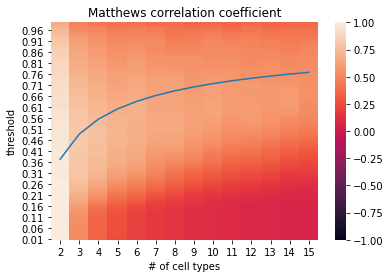

In [46]:
plot_df_mcc = total_df.groupby(["n_cell_types", "threshold"]).agg({"mcc": "mean"}).unstack(level=0)
plot_df_mcc.columns = plot_df_mcc.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_mcc, vmin=-1, vmax=1)
ax.invert_yaxis()

xs = [x+2 for x in range(14)]
ys = 1 - (0.89/np.sqrt(xs))

plt.plot([x+0.5 for x in range(14)], ys*99)

plt.xlabel("# of cell types")
plt.title("Matthews correlation coefficient")

plt.show()

True positive rate: The higher the threshold, the less likely we are to capture the effect on the first cell type correctly

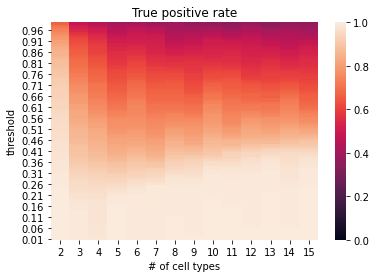

In [21]:
plot_df_tpr = total_df.groupby(["n_cell_types", "threshold"]).agg({"tpr": "mean"}).unstack(level=0)
plot_df_tpr.columns = plot_df_tpr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_tpr, vmin=0, vmax=1)
ax.invert_yaxis()

plt.xlabel("# of cell types")
plt.title("True positive rate")

plt.show()

True negative rate: The lower the threshold, the more likely we are to falsely assess an effect on one of the other cell types (2...K)

K=2 is an edge case, since we set the baseline to the only cell type without an effect, therefore gaining perfect TNR

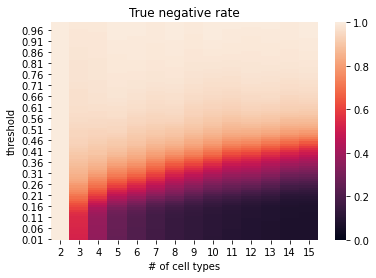

In [22]:
plot_df_tnr = total_df.groupby(["n_cell_types", "threshold"]).agg({"tnr": "mean"}).unstack(level=0)
plot_df_tnr.columns = plot_df_tnr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_tnr, vmin=0, vmax=1)
ax.invert_yaxis()

plt.xlabel("# of cell types")
plt.title("True negative rate")

plt.show()

Now determine the optimal threshold function. We suppose that the function has to be of the form $$t = 1-(c/\sqrt{K})$$.

To find the optimal value for c, we calculate the average MCC for every combination of threshold and K from our benchmark data.
For every c in $$ \{ 0.8, 0.81, \ldots 1.3 \} $$, we determine the threshold t from the function above.
We then get the expected MCC by interpolating our benchmark results for t. 
Finally, we determine the optimal c by comparing the sum of squared MCCs (over all K).

In [61]:
# Grouping of results and interpolaion function
int_df = total_df.groupby(["n_cell_types", "threshold"]).agg({"mcc": "mean"})

def interpolate_score(thresh, k, int_df):
    col = int_df.columns
    residual = (thresh%0.05)
    print(residual)
    low_005 = np.round(thresh - residual, 2)
    
    low_score = pd.Series(int_df.loc[(k, low_005), col])
    high_score = pd.Series(int_df.loc[(k, np.round(low_005 + 0.05, 2)), col])
    print(high_score[:, col] - low_score[:, col])
    
    miss = (high_score - low_score) * (residual/0.05)
    return np.mean((low_score + miss).values[0])

In [12]:
# Do interpolation and make sum of squares
cs = np.round(np.arange(0.8, 1.3, 0.01), 2)
ks = [x+2 for x in range(14)]

ssq_mccs = []

for c in cs:
    ys = 1 - (c/np.sqrt(ks))
    mccs = []
    for i in range(14):
        mccs.append(interpolate_score(ys[i], ks[i], int_df))
    
    ssq = np.sum([m**2 for m in mccs])
    ssq_mccs.append(ssq)
    
print(ssq_mccs)

[5.920364272541862, 5.94455270315586, 5.968801482614278, 5.993037928368255, 6.016543821969279, 6.040057825977338, 6.062979003423546, 6.084817777882263, 6.106514501039172, 6.128260451818424, 6.149957217866675, 6.172266778851421, 6.194634314547956, 6.216118183535719, 6.237663281855191, 6.259205789040731, 6.277280799822199, 6.294541906348459, 6.311448852128662, 6.3267650090711935, 6.342626621626243, 6.354915040923122, 6.365731411190829, 6.376578274593937, 6.387406169119676, 6.397665618442721, 6.405728698282824, 6.413755978983697, 6.421766876176785, 6.429375661459267, 6.436914273687698, 6.444047896410611, 6.451097603945598, 6.455962250261327, 6.458735001944238, 6.4613601948764705, 6.463999218187799, 6.465364162523434, 6.466576777190851, 6.467802810367157, 6.4664533205405474, 6.464574208153573, 6.458178999326409, 6.449973163094866, 6.440740241114023, 6.431577240478104, 6.422484161187108, 6.410741115388313, 6.396643661337025, 6.382334910330622]


{2: 0.01, 3: 0.42, 4: 0.52, 5: 0.56, 6: 0.61, 7: 0.69, 8: 0.69, 9: 0.73, 10: 0.77, 11: 0.78, 12: 0.77, 13: 0.79, 14: 0.8, 15: 0.8}
{2: 0.01, 3: 0.43, 4: 0.49, 5: 0.5, 6: 0.61, 7: 0.55, 8: 0.57, 9: 0.56, 10: 0.62, 11: 0.64, 12: 0.61, 13: 0.62, 14: 0.65, 15: 0.66}


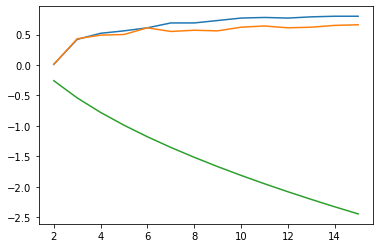

In [48]:
# new approach: Stay at fdr ~10%

grouped_df = total_df.groupby(["n_cell_types", "threshold"]).agg({"fdr": "mean", "mcc": "mean"}).reset_index()
ks = [x+2 for x in range(14)]

threshs_fdr = {}
threshs_mcc = {}

for k in ks:
    smaller_df = grouped_df.loc[(grouped_df["n_cell_types"]==k) & (grouped_df["fdr"]<0.1), :]
    thresh = np.min(smaller_df["threshold"])
    threshs_fdr[k] = thresh
    
    max_mcc = np.max(grouped_df.loc[grouped_df["n_cell_types"]==k, "mcc"])
    threshs_mcc[k] = np.min(grouped_df.loc[(grouped_df["n_cell_types"]==k) & (grouped_df["mcc"]==max_mcc), "threshold"])
    
print(threshs_fdr)
print(threshs_mcc)

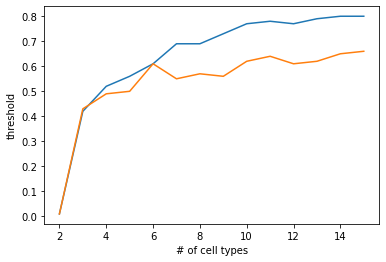

In [62]:
plt.plot(threshs_fdr.keys(), threshs_fdr.values())
plt.plot(threshs_mcc.keys(), threshs_mcc.values())
plt.plot(ks, [0.9-0.63/np.sqrt(k) for k in ks])
plt.plot(ks, [1-0.89/np.sqrt(k) for k in ks])
plt.plot(ks, [1.2-1.41/np.sqrt(k) for k in ks])
plt.plot(ks, [1.1-1.15/np.sqrt(k) for k in ks])

plt.xlabel("# of cell types")
plt.ylabel("threshold")

plt.show()

In [59]:
# Leave out K=2 (edge case)
cs = np.round(np.arange(0.5, 1.5, 0.01), 2)

ssq_fdr = {}
ssq_mcc = {}

for c in cs:
    thresh_prop = np.array([1.1-c/np.sqrt(k) for k in ks[1:]])
    
    diffs_fdr = thresh_prop - np.fromiter(threshs_fdr.values(), dtype=float)[1:]
    ssq_fdr[c] = np.sum(diffs_fdr**2) 
    
    diffs_mcc = thresh_prop - np.fromiter(threshs_mcc.values(), dtype=float)[1:]
    ssq_mcc[c] = np.sum(diffs_mcc**2) 

min_fdr = min(ssq_fdr, key=ssq_fdr.get)
min_mcc = min(ssq_mcc, key=ssq_mcc.get)

print(min_fdr)
print(min_mcc)


1.15
1.39


Optimal threshold: $$ c=1.19 $$

In [13]:
# Get maximum
max_c = cs[ssq_mccs.index(np.max(ssq_mccs))]
print(max_c)

1.19


Plot for supplement

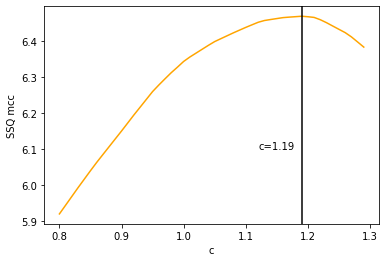

In [14]:
plt.plot(cs, ssq_mccs, color="orange")
plt.axvline(1.19, color="black")
plt.text(x=1.12, y=6.1, s="c=1.19")
plt.xlabel("c")
plt.ylabel("SSQ mcc")
plt.show()

Lets see, if our threshold gives a constant false discovery rate:
    
The heatmap gives not much info, but interpolating the fdr for every K

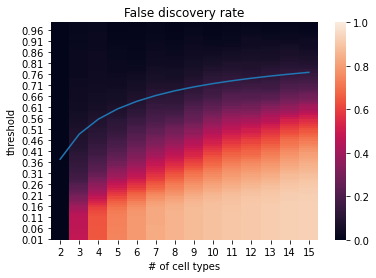

In [47]:
plot_df_fdr = total_df.groupby(["n_cell_types", "threshold"]).agg({"fdr": "mean"}).unstack(level=0)
plot_df_fdr.columns = plot_df_fdr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_fdr, vmin=0, vmax=1)
ax.invert_yaxis()

xs = [x+2 for x in range(14)]
ys = 1 - (0.89/np.sqrt(xs))
plt.plot([x+0.5 for x in range(14)], ys*99)

plt.xlabel("# of cell types")
plt.title("False discovery rate")

plt.show()

In [62]:
fdr_df = total_df.loc[:, ["n_cell_types", "threshold", "fdr"]].set_index(["n_cell_types", "threshold"])

ks = [x+2 for x in range(14)]

ys = 1 - (1/np.sqrt(ks))
# ys = [0.5 for x in range(14)]
fdrs = []
for i in range(1):
    s = interpolate_score(ys[i], ks[i], fdr_df)
    print(s)
    fdrs.append(s)

0.042893218813452524


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
print(fdrs)
        
plt.plot(ks, fdrs)
plt.xlabel("# of cell types")
plt.ylabel("FDR")
plt.show()
        